In [1]:
pip install ahrs

In [2]:
from ahrs.filters import Madgwick, EKF, Mahony
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# List files in the "Colab Notebooks" folder
!ls /content/drive/MyDrive/Colab\ Notebooks/

ahrs_basi.ipynb        imu_data.log		  ori_reference.log
example_jax_gpu.ipynb  imu_pinn_posenc_tpu.ipynb  Suresh_HW4.ipynb


In [5]:
# Load the reference file
file_path_ref = '/content/drive/MyDrive/Colab Notebooks/ori_reference.log'
with open(file_path_ref, 'r') as file:
    lines = file.readlines()

In [6]:
# Filter out lines from the reference file that start with "//"
filtered_lines = [line for line in lines if not line.strip().startswith('//')]

In [7]:
# Write the filtered lines to a temporary CSV file
temp_file_path = 'filtered_data.csv'
with open(temp_file_path, 'w') as file:
    file.writelines(filtered_lines)

In [8]:
# Read the CSV file and specify that the second row contains the headers
df_ref = pd.read_csv(temp_file_path, header=1)

In [9]:
# Load the data file
file_path = '/content/drive/MyDrive/Colab Notebooks/imu_data.log'
with open(file_path, 'r') as file:
    data = file.readlines()

In [10]:
# Locate where the actual data starts
data_start_index = None
for index, line in enumerate(data):
    if not line.startswith('//'):
        data_start_index = index
        break

In [11]:
# Read the data into a DataFrame, skipping the initial metadata lines
df = pd.read_csv(file_path, skiprows=data_start_index)

In [12]:
# Truncate indices
content_str = "long_motion_trial"
example_idx = 2

truncate_start_idx = None
if content_str == "low_freq_trend":
    truncate_start_idx_list = [8000, 10000, 11000, 12000]
elif content_str == "high_freq_trend":
    truncate_start_idx_list = [90837, 110726, 262387, 220502]
elif content_str == "short_motion_trials":
    truncate_start_idx_list = [65425, 89728, 109876, 129086, 145223, 157175, 174895, 203979, 219302, 236081, 261587]

truncate_length = 1000

truncate_start_idx_long_motion_trial = 5530
if content_str == "long_motion_trial":
    truncate_start_idx = truncate_start_idx_long_motion_trial
else:
    truncate_start_idx = truncate_start_idx_list[example_idx]

truncate_start_ref_idx = None
while truncate_start_ref_idx is None:
    if df['SampleTimeFine'][truncate_start_idx] in df_ref['SampleTimeFine'].values:
        truncate_start_ref_idx = df_ref[df_ref['SampleTimeFine'] == df['SampleTimeFine'][truncate_start_idx]].index[0]
    else:
        truncate_start_idx += 1

truncate_end_idx_motion_trial_list = [68081, 92346, 112377, 132121, 148485, 161354, 181312, 206868, 222175, 240078, 264468]
truncate_end_idx_long_motion_trial = 64481
if content_str == "short_motion_trials":
    truncate_end_idx = truncate_end_idx_motion_trial_list[example_idx]
elif content_str == "long_motion_trial":
    truncate_end_idx = truncate_end_idx_long_motion_trial
else:
    truncate_end_idx = truncate_start_idx + truncate_length

truncate_end_ref_idx = None
while truncate_end_ref_idx is None:
    if df['SampleTimeFine'][truncate_end_idx] in df_ref['SampleTimeFine'].values:
        truncate_end_ref_idx = df_ref[df_ref['SampleTimeFine'] == df['SampleTimeFine'][truncate_end_idx]].index[0]
    else:
        truncate_end_idx += 1

In [13]:
# Extract and normalize timestamps
t_raw_array = np.array(df['SampleTimeFine'].values).reshape(-1, 1)
t_array_full = 10**-4 * (t_raw_array - t_raw_array[0])
t_array = t_array_full[truncate_start_idx:truncate_end_idx, :]

# Extract and normalize reference timestamps
t_ref_raw_array = np.array(df_ref['SampleTimeFine'].values).reshape(-1, 1)
t_ref_array_full = 10**-4 * (t_ref_raw_array - t_ref_raw_array[0])
t_ref_array = t_ref_array_full[truncate_start_ref_idx:truncate_end_ref_idx, :]

# Extract accelerometer and gyroscope data
data_acc_full = np.array(df[['Acc_X', 'Acc_Y', 'Acc_Z']].values.tolist())
data_gyro_full = np.array(df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].values.tolist())

# Truncate accelerometer and gyroscope data
data_acc = data_acc_full[truncate_start_idx:truncate_end_idx, :]
data_gyro = data_gyro_full[truncate_start_idx:truncate_end_idx, :]

# Extract reference orientation data
data_quat_full = np.array(df_ref[list(df_ref.columns[1:])].values.tolist())

# Truncate reference orientation data
data_quat = data_quat_full[truncate_start_ref_idx:truncate_end_ref_idx, :]

# Assign the boundary condition orientation
q_bc_left = data_quat[0]
q_bc_right = data_quat[-1]

In [14]:
# Apply Madgwick filter
madgwick = Madgwick(gyr=data_gyro, acc=data_acc, q0=q_bc_left, Dt=0.0025)
final_q_t_array = madgwick.Q

Text(0.5, 1.0, 'orientation results (quaternions)')

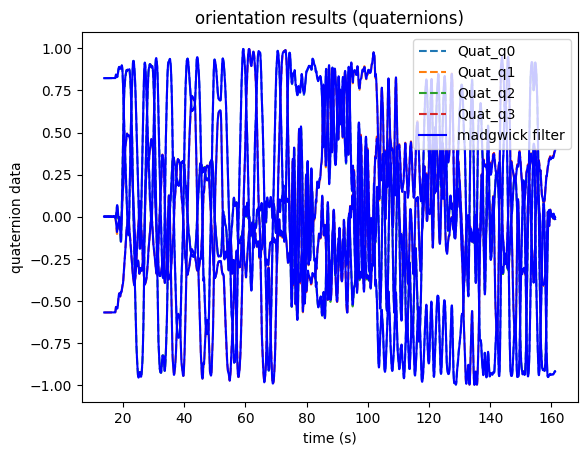

In [15]:
# Plot final prediction for orientation in terms of quaternions
quat_column_names = list(df_ref.columns[1:])
plt.figure()
[plt.plot(t_ref_array, data_quat[:, i], '--', label=quat_column_names[i]) for i in range(data_quat.shape[1])]
for i in range(final_q_t_array.shape[1]):
    if i == 0:
        plt.plot(t_array, final_q_t_array[:, i], 'b', label="madgwick filter")
    else:
        plt.plot(t_array, final_q_t_array[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("quaternion data")
plt.title("orientation results (quaternions)")

In [16]:
# Extract inclination and heading from quaternions
def quat_to_rpy(quat):
    w, x, y, z = quat
    roll = jnp.arctan2(2.0 * (w * x + y * z), 1.0 - 2.0 * (x * x + y * y))
    pitch = jnp.arcsin(2.0 * (w * y - z * x))
    yaw = jnp.arctan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    return jnp.array([roll, pitch, yaw])

# Vectorized conversion
rpy_angles_ref_rad = jax.vmap(quat_to_rpy)(jnp.array(data_quat))
rpy_angles_madgwick_rad = jax.vmap(quat_to_rpy)(jnp.array(final_q_t_array))

# Convert the angles from radians to degrees
rpy_angles_ref = jnp.degrees(rpy_angles_ref_rad)
rpy_angles_madgwick = jnp.degrees(rpy_angles_madgwick_rad)

In [17]:
# Check if t_ref_array is not 1D, reshape it to 1D if needed
t_ref_array = t_ref_array.flatten()

# Set error bar value
error_bar_val_roll = 1.0
error_bar_val_pitch = 2.0
error_bar_val_yaw = 5.0

Text(0.5, 1.0, 'roll results')

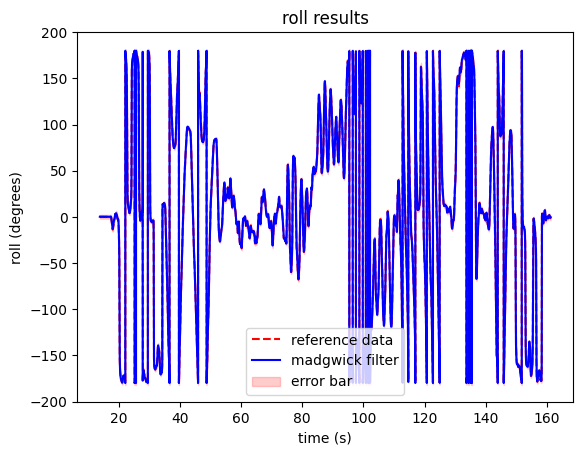

In [18]:
# Plot final prediction for roll
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,0], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_madgwick[:,0], 'b', label="madgwick filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,0]-error_bar_val_pitch, rpy_angles_ref[:,0]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("roll (degrees)")
plt.title("roll results")

Text(0.5, 1.0, 'pitch results')

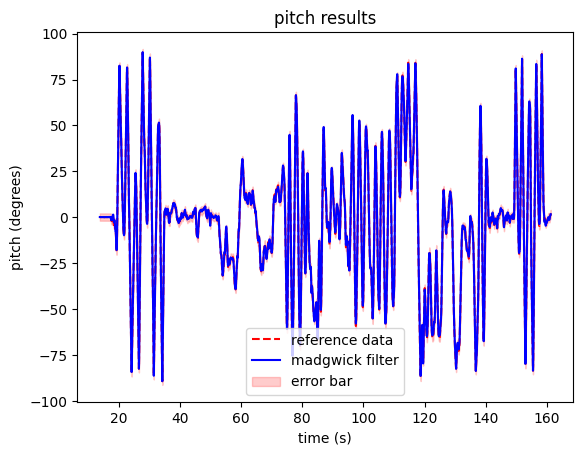

In [19]:
# Plot final prediction for pitch
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,1], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_madgwick[:,1], 'b', label="madgwick filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,1]-error_bar_val_pitch, rpy_angles_ref[:,1]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("pitch (degrees)")
plt.title("pitch results")

Text(0.5, 1.0, 'yaw results')

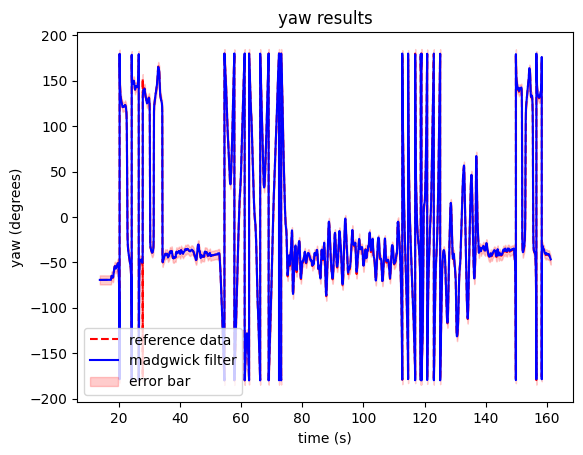

In [20]:
# Plot final prediction for yaw
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,2], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_madgwick[:,2], 'b', label="madgwick filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,2]-error_bar_val_yaw, rpy_angles_ref[:,2]+error_bar_val_yaw, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("yaw (degrees)")
plt.title("yaw results")

In [21]:
# Apply Mahony filter
mahony = Mahony(gyr=data_gyro, acc=data_acc, q0=q_bc_left, Dt=0.0025)
final_q_t_array_mahony = mahony.Q

Text(0.5, 1.0, 'orientation results (quaternions)')

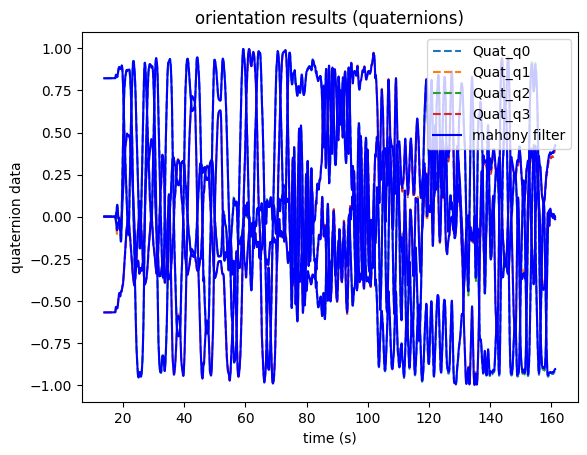

In [22]:
# Plot final prediction for orientation in terms of quaternions
quat_column_names = list(df_ref.columns[1:])
plt.figure()
[plt.plot(t_ref_array, data_quat[:, i], '--', label=quat_column_names[i]) for i in range(data_quat.shape[1])]
for i in range(final_q_t_array_mahony.shape[1]):
    if i == 0:
        plt.plot(t_array, final_q_t_array_mahony[:, i], 'b', label="mahony filter")
    else:
        plt.plot(t_array, final_q_t_array_mahony[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("quaternion data")
plt.title("orientation results (quaternions)")

In [23]:
# Extract Euler angles for Mahony filter in degrees
rpy_angles_mahony_rad = jax.vmap(quat_to_rpy)(jnp.array(final_q_t_array_mahony))
rpy_angles_mahony = jnp.degrees(rpy_angles_mahony_rad)

Text(0.5, 1.0, 'roll results')

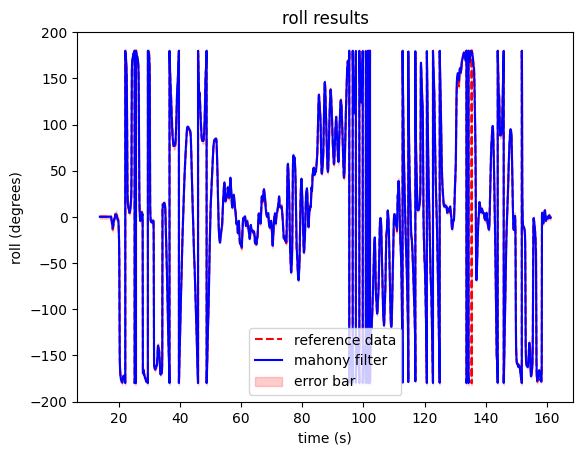

In [24]:
# Plot final prediction for roll
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,0], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_mahony[:,0], 'b', label="mahony filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,0]-error_bar_val_pitch, rpy_angles_ref[:,0]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("roll (degrees)")
plt.title("roll results")

Text(0.5, 1.0, 'pitch results')

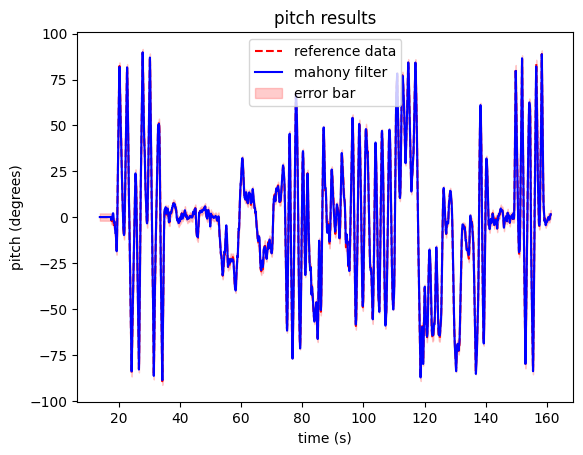

In [25]:
# Plot final prediction for pitch
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,1], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_mahony[:,1], 'b', label="mahony filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,1]-error_bar_val_pitch, rpy_angles_ref[:,1]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("pitch (degrees)")
plt.title("pitch results")

Text(0.5, 1.0, 'yaw results')

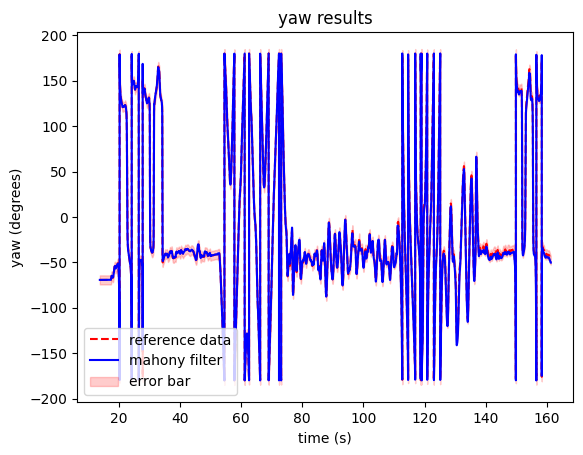

In [26]:
# Plot final prediction for yaw
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,2], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_mahony[:,2], 'b', label="mahony filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,2]-error_bar_val_yaw, rpy_angles_ref[:,2]+error_bar_val_yaw, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("yaw (degrees)")
plt.title("yaw results")

In [27]:
# Apply EKF filter
ekf = EKF(gyr=data_gyro, acc=data_acc, q0=q_bc_left, Dt=0.0025)
final_q_t_array_ekf = ekf.Q

Text(0.5, 1.0, 'orientation results (quaternions)')

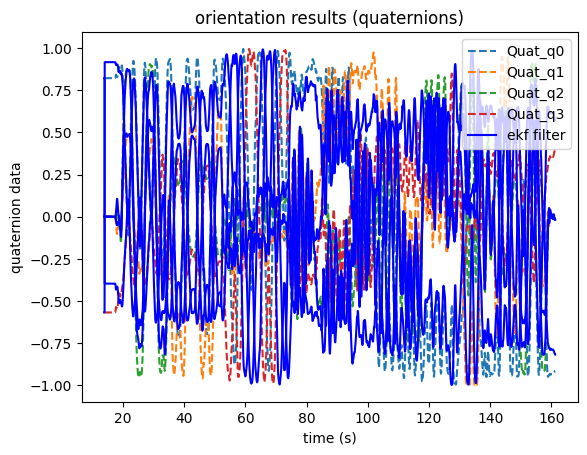

In [28]:
# Plot final prediction for orientation in terms of quaternions
quat_column_names = list(df_ref.columns[1:])
plt.figure()
[plt.plot(t_ref_array, data_quat[:, i], '--', label=quat_column_names[i]) for i in range(data_quat.shape[1])]
for i in range(final_q_t_array_ekf.shape[1]):
    if i == 0:
        plt.plot(t_array, final_q_t_array_ekf[:, i], 'b', label="ekf filter")
    else:
        plt.plot(t_array, final_q_t_array_ekf[:, i], 'b')
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("quaternion data")
plt.title("orientation results (quaternions)")

In [29]:
# Extract Euler angles for EKF filter in degrees
rpy_angles_ekf_rad = jax.vmap(quat_to_rpy)(jnp.array(final_q_t_array_ekf))
rpy_angles_ekf = jnp.degrees(rpy_angles_ekf_rad)

Text(0.5, 1.0, 'roll results')

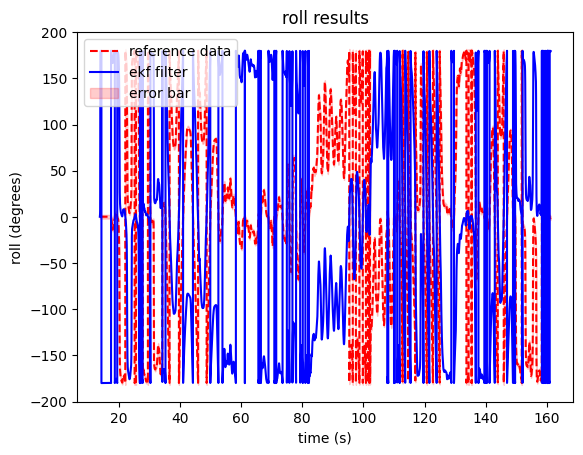

In [30]:
# Plot final prediction for roll
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,0], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_ekf[:,0], 'b', label="ekf filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,0]-error_bar_val_pitch, rpy_angles_ref[:,0]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("roll (degrees)")
plt.title("roll results")

Text(0.5, 1.0, 'pitch results')

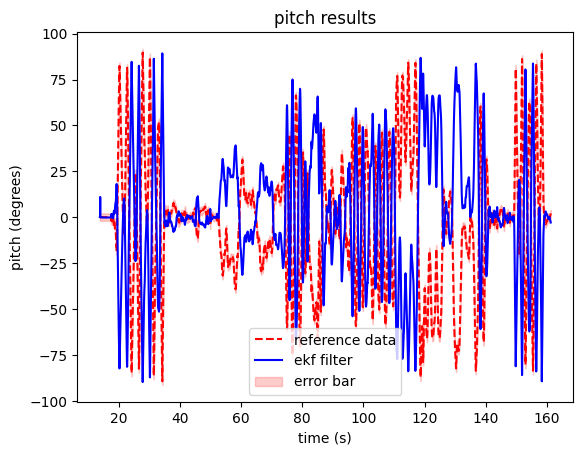

In [31]:
# Plot final prediction for pitch
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,1], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_ekf[:,1], 'b', label="ekf filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,1]-error_bar_val_pitch, rpy_angles_ref[:,1]+error_bar_val_pitch, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("pitch (degrees)")
plt.title("pitch results")

Text(0.5, 1.0, 'yaw results')

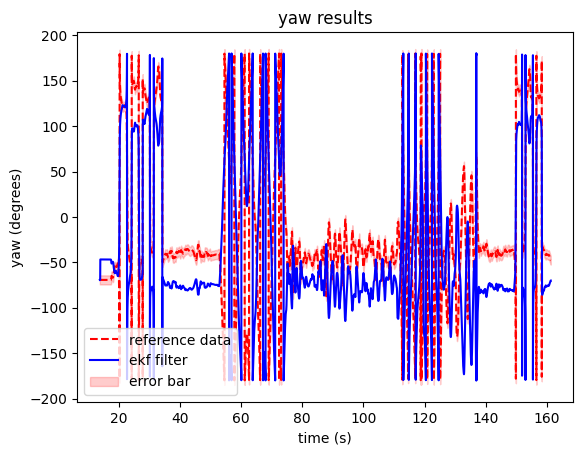

In [32]:
# Plot final prediction for yaw
plt.figure()
plt.plot(t_ref_array, rpy_angles_ref[:,2], 'r--', label="reference data")
plt.plot(t_array, rpy_angles_ekf[:,2], 'b', label="ekf filter")
plt.fill_between(t_ref_array, rpy_angles_ref[:,2]-error_bar_val_yaw, rpy_angles_ref[:,2]+error_bar_val_yaw, color='r', alpha=0.2, label="error bar")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("yaw (degrees)")
plt.title("yaw results")